
                    SIMULAÇÃO REALISTA DE TRADING - B3 2026
Saldo Inicial: R$ 10,000.00
Taxa B3: 0.030% | Slippage: 0.010%
IR Swing Trade: 15.0% | IR Day Trade: 20.0%
Isenção Mensal: R$ 20,000.00
Pasta de Dados: C:\Users\leona\OneDrive\Área de Trabalho\Machine-Learning---Stock-Prediction\CodigoExperimentos\ExperimentoFeatures\Resultados_Unificados


Processando BEEF3.SA...

  Buscando: Janela_1
  Caminho: C:\Users\leona\OneDrive\Área de Trabalho\Machine-Learning---Stock-Prediction\CodigoExperimentos\ExperimentoFeatures\Resultados_Unificados\BEEF3.SA\Previsoes\BEEF3.SA_Janela_1_previsoes_teste_final.csv
  ✓ Arquivo encontrado! Shape: (364, 3)

--- Simulação para 2023-01-02 ---
Min: 18.804249, Max: 21.148592, Média: 19.66034334065934

📊 Resumo de Vendas Mensais:
Resultado: Retorno Líquido=-37.69%, Sharpe=-0.74, Total IR=0.00

  Buscando: Janela_2
  Caminho: C:\Users\leona\OneDrive\Área de Trabalho\Machine-Learning---Stock-Prediction\CodigoExperimentos\ExperimentoFeatures\Resultados_Unif

C:\Users\leona\AppData\Local\Temp\ipykernel_528\3764272774.py:515: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\leona\AppData\Local\Temp\ipykernel_528\3764272774.py:515: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\leona\AppData\Local\Temp\ipykernel_528\3764272774.py:518: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.savefig(grafico_filepath, dpi=300, bbox_inches='tight')
C:\Users\leona\AppData\Local\Temp\ipykernel_528\3764272774.py:518: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig(grafico_filepath, dpi=300, bbox_inches='tight')


✓ Gráfico salvo em: C:\Users\leona\OneDrive\Área de Trabalho\Machine-Learning---Stock-Prediction\CodigoTrade\FeaturesMacroMicroResultados\trading_realista_features_completo.png


c:\Users\leona\OneDrive\Área de Trabalho\Machine-Learning---Stock-Prediction\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\leona\OneDrive\Área de Trabalho\Machine-Learning---Stock-Prediction\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


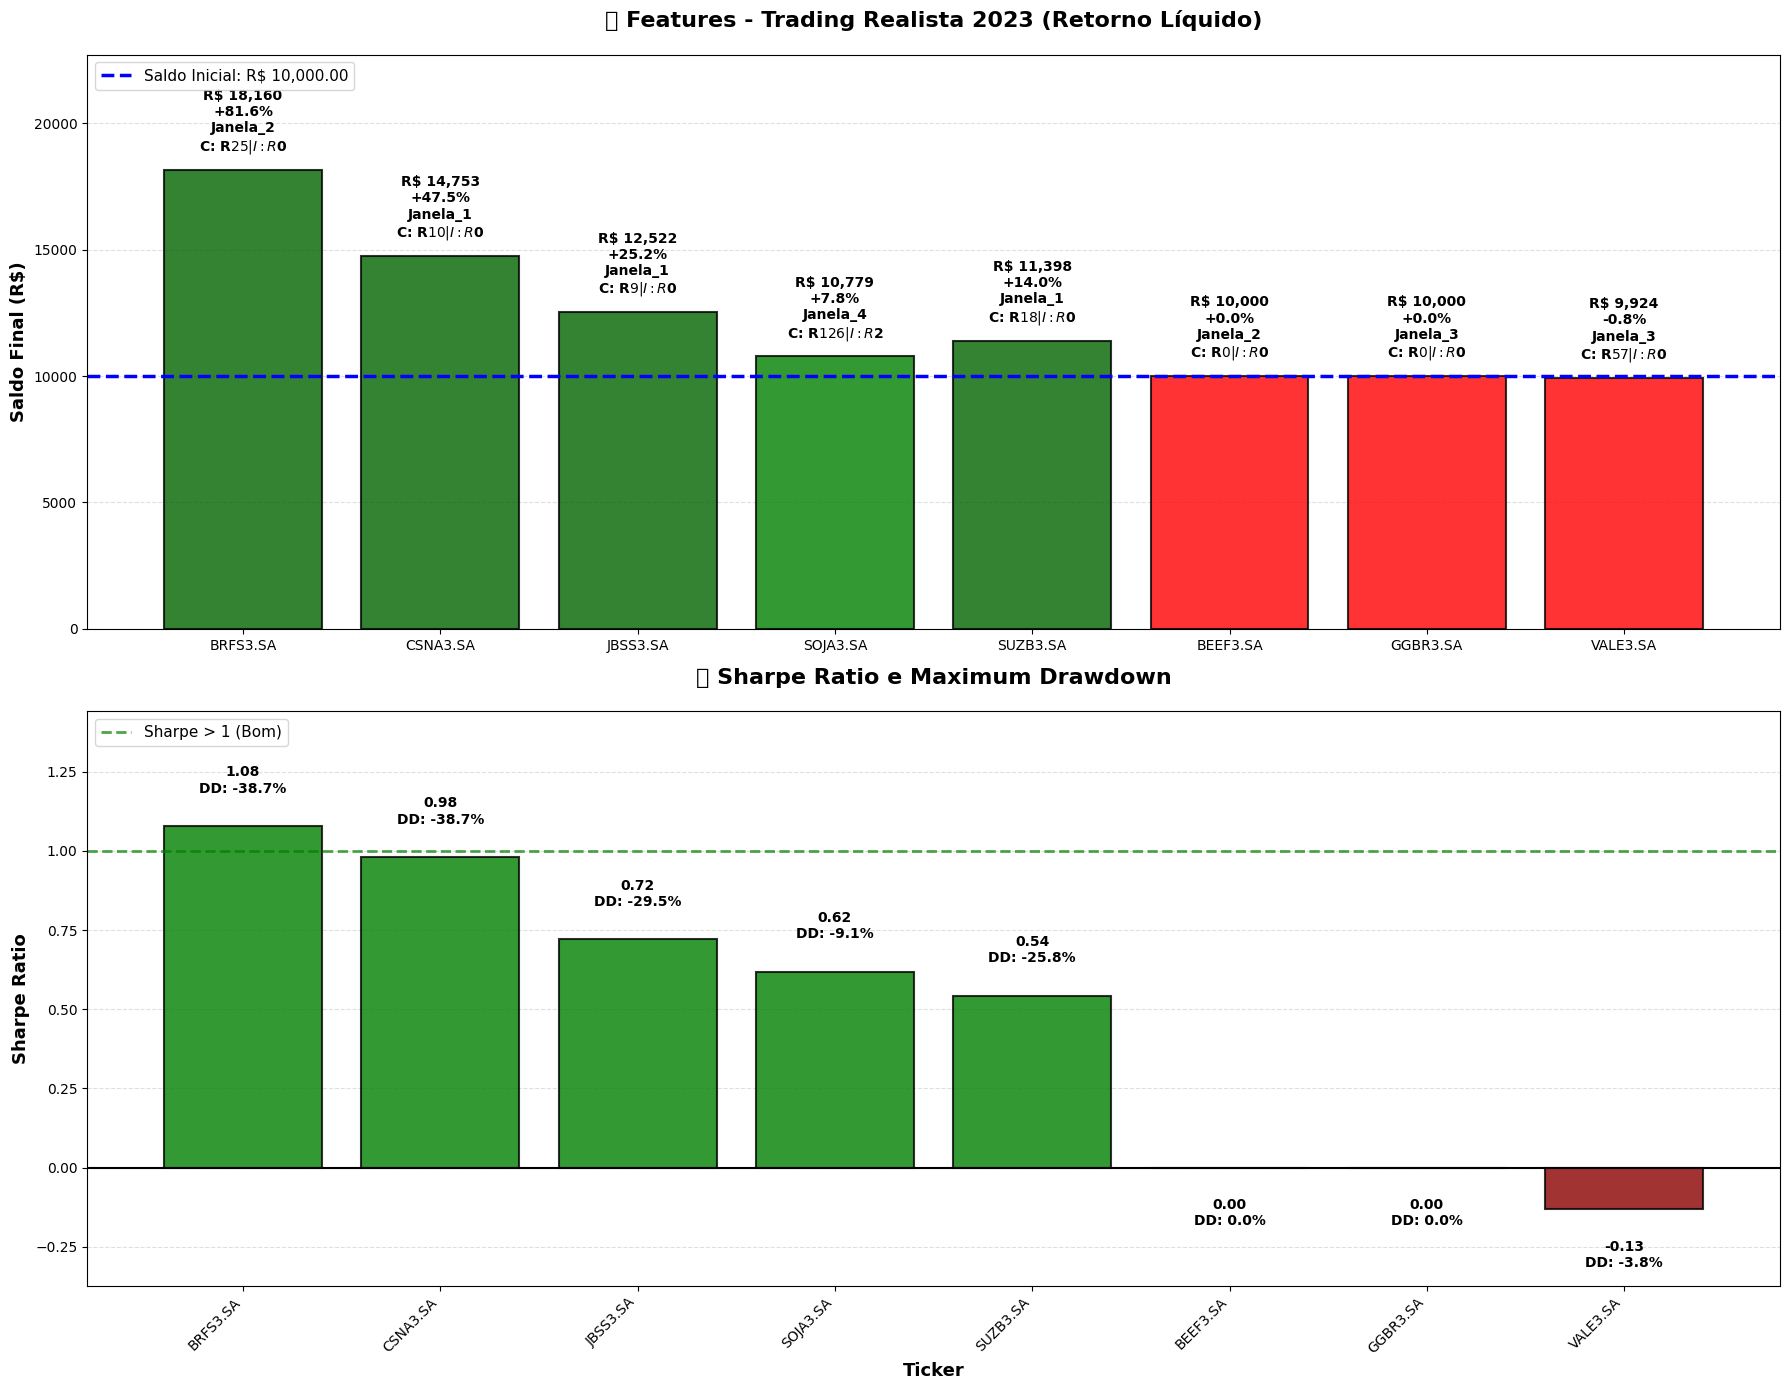


                              ✅ EXECUÇÃO CONCLUÍDA


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from datetime import datetime 

# --- Parâmetros Reais de Mercado (B3 2026) ---
TAXA_NEGOCIACAO_LIQUIDACAO = 0.00030  # 0,03%
TAXA_DAY_TRADE = 0.00023              # 0,023%
SLIPPAGE = 0.0001                     # 0,01%
IR_SWING_TRADE = 0.15                 # 15%
IR_DAY_TRADE = 0.20                   # 20%
ISENCAO_VENDA_MENSAL = 20000          # R$ 20k

# Diretório HIERÁRQUICO onde estão os arquivos de previsões (ALTERADO)
input_dir = r"C:\Users\leona\OneDrive\Área de Trabalho\Machine-Learning---Stock-Prediction\CodigoExperimentos\ExperimentoFeatures\Resultados_Unificados"

# Diretório onde os resultados serão salvos
output_dir = r"C:\Users\leona\OneDrive\Área de Trabalho\Machine-Learning---Stock-Prediction\CodigoTrade\FeaturesMacroMicroResultados"
os.makedirs(output_dir, exist_ok=True)

transactions_dir = os.path.join(output_dir, "Transacoes")
os.makedirs(transactions_dir, exist_ok=True)

# Lista de tickers
tickers = ["BEEF3.SA", "BRFS3.SA", "VALE3.SA", "JBSS3.SA", "SOJA3.SA", 
           "SUZB3.SA", "GGBR3.SA", "CSNA3.SA"]

# Lista de janelas (AJUSTADO para o formato Features)
janelas = ["Janela_1", "Janela_2", "Janela_3", "Janela_4"]

def calcular_metricas_risco(historico_patrimonio, saldo_inicial):
    """Calcula Maximum Drawdown e Sharpe Ratio."""
    if not historico_patrimonio or len(historico_patrimonio) < 2:
        return {'max_drawdown': 0.0, 'sharpe_ratio': 0.0}
    
    patrimonio_array = np.array(historico_patrimonio)
    pico = np.maximum.accumulate(patrimonio_array)
    drawdown = (patrimonio_array - pico) / pico
    max_drawdown = np.min(drawdown) * 100
    
    retornos = np.diff(patrimonio_array) / patrimonio_array[:-1]
    if len(retornos) > 0 and np.std(retornos) != 0:
        sharpe_ratio = np.mean(retornos) / np.std(retornos) * np.sqrt(252)
    else:
        sharpe_ratio = 0.0
    
    return {
        'max_drawdown': max_drawdown,
        'sharpe_ratio': sharpe_ratio
    }

def estrategia_all_in_realista(dados_brutos, saldo_inicial):
    """Estratégia All-In com custos reais da B3 e IR CORRIGIDO."""
    dados = dados_brutos.copy()
    dados['Preço Real'] = pd.to_numeric(dados['Preço Real'], errors='coerce')
    dados['Preço Previsto'] = pd.to_numeric(dados['Preço Previsto'], errors='coerce')
    dados['Data'] = pd.to_datetime(dados['Data'])
    
    previsoes = dados['Preço Previsto'].dropna()
    min_previsto = previsoes.min() if len(previsoes) > 0 else None
    max_previsto = previsoes.max() if len(previsoes) > 0 else None
    media_previsoes = previsoes.mean() if len(previsoes) > 0 else None
    
    identifier = dados_brutos['Data'].iloc[0] if not dados_brutos.empty else "Unknown"
    print(f"\n--- Simulação para {identifier} ---")
    print(f"Min: {min_previsto}, Max: {max_previsto}, Média: {media_previsoes}")
    
    # Bloquear previsões extremas
    is_extremely_negative = False
    if min_previsto is not None and isinstance(min_previsto, (int, float)) and min_previsto < -1000:
        is_extremely_negative = True
        print(f"!!! Previsão mínima ({min_previsto}) < -1000. Bloqueando transações. !!!")
    
    if is_extremely_negative:
        diagnostico = {
            'Previsões Razoáveis': False,
            'Estratégia Usada': 'Sem transações - Previsões Negativas',
            'Total de Transações': 0,
            'Retorno (%)': 0.0,
            'Retorno Liquido (%)': 0.0,
            'Max Drawdown (%)': 0.0,
            'Sharpe Ratio': 0.0,
            'Total Custos (R$)': 0.0,
            'Total Impostos (R$)': 0.0,
            'Min Previsto': min_previsto,
            'Max Previsto': max_previsto,
            'Média Previsto': media_previsoes
        }
        return saldo_inicial, [], diagnostico
    
    # Inicializar variáveis
    saldo = saldo_inicial
    quantidade_acoes = 0
    transacoes = []
    historico_patrimonio = [saldo_inicial]
    
    total_custos_operacionais = 0.0
    total_impostos = 0.0
    vendas_no_mes = {}  # ✅ (ano, mês): valor_vendas_acumulado
    data_compra = None
    preco_compra = 0.0
    
    for i in range(len(dados) - 1):
        data_atual = dados.iloc[i]['Data']
        preco_real = dados.iloc[i]['Preço Real']
        
        if pd.isna(preco_real) or preco_real <= 0:
            continue
        
        preco_previsto = dados.iloc[i + 1]['Preço Previsto']
        if pd.isna(preco_previsto):
            continue
        
        # COMPRA
        if quantidade_acoes == 0 and preco_previsto > preco_real:
            preco_com_slippage = preco_real * (1 + SLIPPAGE)
            custos_compra = saldo * (TAXA_NEGOCIACAO_LIQUIDACAO + SLIPPAGE)
            saldo_pos_custo = saldo - custos_compra
            
            if saldo_pos_custo > 0:
                quantidade_acoes = saldo_pos_custo / preco_com_slippage
                valor_investido = quantidade_acoes * preco_com_slippage
                saldo = 0
                total_custos_operacionais += custos_compra
                
                data_compra = data_atual
                preco_compra = preco_com_slippage
                
                transacoes.append({
                    'Data': data_atual,
                    'Acao': 'Compra',
                    'Preco': preco_real,
                    'Preco_Executado': preco_com_slippage,
                    'Quantidade': quantidade_acoes,
                    'Valor_Total': valor_investido,
                    'Custos_Operacionais': custos_compra,
                    'Saldo_Restante': saldo
                })
        
        # VENDA
        elif quantidade_acoes > 0 and preco_previsto < preco_real and i < len(dados) - 2:
            preco_com_slippage = preco_real * (1 - SLIPPAGE)
            valor_bruto_venda = quantidade_acoes * preco_com_slippage
            custos_venda = valor_bruto_venda * (TAXA_NEGOCIACAO_LIQUIDACAO + SLIPPAGE)
            
            is_day_trade = (data_atual.date() == data_compra.date()) if data_compra else False
            
            custo_aquisicao = quantidade_acoes * preco_compra
            lucro_bruto = valor_bruto_venda - custo_aquisicao - custos_venda
            
            imposto = 0.0
            mes_ano = (data_atual.year, data_atual.month)
            
            # ✅ LOG DETALHADO PARA DEBUG
            vendas_mes_atual = vendas_no_mes.get(mes_ano, 0.0)
            print(f"  [VENDA] Data: {data_atual.date()} | Venda: R$ {valor_bruto_venda:.2f} | "
                  f"Vendas Mês {mes_ano}: R$ {vendas_mes_atual:.2f} | Lucro: R$ {lucro_bruto:.2f}")
            
            if lucro_bruto > 0:
                if is_day_trade:
                    # Day Trade: SEMPRE cobra 20%
                    imposto = lucro_bruto * IR_DAY_TRADE
                    print(f"    → DAY TRADE: IR = R$ {imposto:.2f} (20% sobre lucro)")
                else:
                    # ✅ SWING TRADE: Lógica CORRIGIDA
                    vendas_anteriores = vendas_no_mes.get(mes_ano, 0.0)
                    vendas_totais_mes = vendas_anteriores + valor_bruto_venda
                    
                    if vendas_totais_mes > ISENCAO_VENDA_MENSAL:
                        if vendas_anteriores >= ISENCAO_VENDA_MENSAL:
                            # Já ultrapassou antes: tributa TUDO
                            imposto = lucro_bruto * IR_SWING_TRADE
                            print(f"    → SWING: Mês já ultrapassou isenção | IR = R$ {imposto:.2f}")
                        else:
                            # Primeira vez ultrapassando: tributar proporcionalmente
                            valor_excedente = vendas_totais_mes - ISENCAO_VENDA_MENSAL
                            proporcao_tributavel = valor_excedente / valor_bruto_venda
                            lucro_tributavel = lucro_bruto * proporcao_tributavel
                            imposto = lucro_tributavel * IR_SWING_TRADE
                            print(f"    → SWING: 1ª vez ultrapassando | Excedente: R$ {valor_excedente:.2f} | "
                                  f"Proporção: {proporcao_tributavel:.2%} | IR = R$ {imposto:.2f}")
                    else:
                        print(f"    → SWING: Dentro da isenção (R$ 20k/mês) | IR = R$ 0.00")
                    
                    # Atualizar contador do mês
                    vendas_no_mes[mes_ano] = vendas_totais_mes
            
            valor_liquido_venda = valor_bruto_venda - custos_venda - imposto
            saldo = valor_liquido_venda
            total_custos_operacionais += custos_venda
            total_impostos += imposto
            
            transacoes.append({
                'Data': data_atual,
                'Acao': 'Venda Day Trade' if is_day_trade else 'Venda',
                'Preco': preco_real,
                'Preco_Executado': preco_com_slippage,
                'Quantidade': quantidade_acoes,
                'Valor_Bruto': valor_bruto_venda,
                'Custos_Operacionais': custos_venda,
                'Lucro_Bruto': lucro_bruto,
                'Imposto': imposto,
                'Valor_Liquido': valor_liquido_venda,
                'Saldo_Restante': saldo,
                'Vendas_Acumuladas_Mes': vendas_no_mes.get(mes_ano, 0.0)  # ✅ NOVO CAMPO
            })
            
            quantidade_acoes = 0
            data_compra = None
        
        patrimonio_atual = saldo + (quantidade_acoes * preco_real if quantidade_acoes > 0 else 0)
        historico_patrimonio.append(patrimonio_atual)
    
    # Venda final (MESMA LÓGICA)
    if quantidade_acoes > 0:
        ultimo_preco = dados.iloc[-1]['Preço Real']
        data_final = dados.iloc[-1]['Data']
        
        if not pd.isna(ultimo_preco) and ultimo_preco > 0:
            preco_com_slippage = ultimo_preco * (1 - SLIPPAGE)
            valor_bruto_venda = quantidade_acoes * preco_com_slippage
            custos_venda = valor_bruto_venda * (TAXA_NEGOCIACAO_LIQUIDACAO + SLIPPAGE)
            
            is_day_trade = (data_final.date() == data_compra.date()) if data_compra else False
            
            custo_aquisicao = quantidade_acoes * preco_compra
            lucro_bruto = valor_bruto_venda - custo_aquisicao - custos_venda
            
            imposto = 0.0
            mes_ano = (data_final.year, data_final.month)
            
            if lucro_bruto > 0:
                if is_day_trade:
                    imposto = lucro_bruto * IR_DAY_TRADE
                else:
                    vendas_anteriores = vendas_no_mes.get(mes_ano, 0.0)
                    vendas_totais_mes = vendas_anteriores + valor_bruto_venda
                    
                    if vendas_totais_mes > ISENCAO_VENDA_MENSAL:
                        if vendas_anteriores >= ISENCAO_VENDA_MENSAL:
                            imposto = lucro_bruto * IR_SWING_TRADE
                        else:
                            valor_excedente = vendas_totais_mes - ISENCAO_VENDA_MENSAL
                            proporcao_tributavel = valor_excedente / valor_bruto_venda
                            lucro_tributavel = lucro_bruto * proporcao_tributavel
                            imposto = lucro_tributavel * IR_SWING_TRADE
                    
                    vendas_no_mes[mes_ano] = vendas_totais_mes
            
            valor_liquido_venda = valor_bruto_venda - custos_venda - imposto
            saldo = valor_liquido_venda
            total_custos_operacionais += custos_venda
            total_impostos += imposto
            
            transacoes.append({
                'Data': data_final,
                'Acao': 'Venda Final',
                'Preco': ultimo_preco,
                'Preco_Executado': preco_com_slippage,
                'Quantidade': quantidade_acoes,
                'Valor_Bruto': valor_bruto_venda,
                'Custos_Operacionais': custos_venda,
                'Lucro_Bruto': lucro_bruto,
                'Imposto': imposto,
                'Valor_Liquido': valor_liquido_venda,
                'Saldo_Restante': saldo,
                'Vendas_Acumuladas_Mes': vendas_no_mes.get(mes_ano, 0.0)
            })
    
    # ✅ RESUMO MENSAL DE IR (DEBUG)
    print(f"\n📊 Resumo de Vendas Mensais:")
    for mes_ano, total_vendas in sorted(vendas_no_mes.items()):
        status = "TRIBUTÁVEL" if total_vendas > ISENCAO_VENDA_MENSAL else "ISENTO"
        print(f"  {mes_ano[1]:02d}/{mes_ano[0]}: R$ {total_vendas:,.2f} [{status}]")
    
    metricas_risco = calcular_metricas_risco(historico_patrimonio, saldo_inicial)
    
    retorno_bruto = ((saldo + total_custos_operacionais + total_impostos - saldo_inicial) / saldo_inicial) * 100
    retorno_liquido = ((saldo - saldo_inicial) / saldo_inicial) * 100
    
    previsoes_razoaveis = not is_extremely_negative
    estrategia_usada = 'Trading Realista (B3)' if len(transacoes) > 0 else 'Sem transações'
    
    diagnostico = {
        'Previsões Razoáveis': previsoes_razoaveis,
        'Estratégia Usada': estrategia_usada,
        'Total de Transações': len(transacoes),
        'Retorno Bruto (%)': retorno_bruto,
        'Retorno Liquido (%)': retorno_liquido,
        'Max Drawdown (%)': metricas_risco['max_drawdown'],
        'Sharpe Ratio': metricas_risco['sharpe_ratio'],
        'Total Custos (R$)': total_custos_operacionais,
        'Total Impostos (R$)': total_impostos,
        'Min Previsto': min_previsto,
        'Max Previsto': max_previsto,
        'Média Previsto': media_previsoes
    }
    
    print(f"Resultado: Retorno Líquido={retorno_liquido:.2f}%, Sharpe={metricas_risco['sharpe_ratio']:.2f}, Total IR={total_impostos:.2f}")
    
    return saldo, transacoes, diagnostico

def processar_previsoes_realista(input_dir, tickers, janelas, saldo_inicial):
    """
    Processa previsões com estrutura HIERÁRQUICA de pastas.
    Formato esperado: TICKER/Previsoes/TICKER_JANELA_X_previsoes_teste_final.csv
    """
    resultados = []
    todas_transacoes = {}
    todos_diagnosticos = {}
    
    for ticker in tickers:
        print(f"\n{'='*60}")
        print(f"Processando {ticker}...")
        print(f"{'='*60}")
        
        ticker_resultados = {'Ticker': ticker}
        todas_transacoes[ticker] = {}
        todos_diagnosticos[ticker] = {}
        
        for janela in janelas:
            # ALTERADO: Caminho hierárquico
            previsoes_file = os.path.join(input_dir, ticker, "Previsoes", f"{ticker}_{janela}_previsoes_teste_final.csv")
            
            print(f"\n  Buscando: {janela}")
            print(f"  Caminho: {previsoes_file}")
            
            if os.path.exists(previsoes_file):
                try:
                    dados = pd.read_csv(previsoes_file)
                    print(f"  ✓ Arquivo encontrado! Shape: {dados.shape}")
                    
                    saldo_final, transacoes, diagnostico = estrategia_all_in_realista(dados, saldo_inicial)
                    
                    todas_transacoes[ticker][janela] = transacoes
                    todos_diagnosticos[ticker][janela] = diagnostico
                    
                    ticker_resultados[f"Saldo Final {janela}"] = saldo_final
                    ticker_resultados[f"Retorno Liquido {janela} (%)"] = diagnostico['Retorno Liquido (%)']
                    ticker_resultados[f"Sharpe {janela}"] = diagnostico['Sharpe Ratio']
                    ticker_resultados[f"Drawdown {janela} (%)"] = diagnostico['Max Drawdown (%)']
                    ticker_resultados[f"Custos {janela} (R$)"] = diagnostico['Total Custos (R$)']
                    ticker_resultados[f"Impostos {janela} (R$)"] = diagnostico['Total Impostos (R$)']
                    
                except Exception as e:
                    print(f"  ❌ Erro ao processar {ticker} - {janela}: {str(e)}")
                    import traceback
                    traceback.print_exc()
                    
                    ticker_resultados[f"Saldo Final {janela}"] = saldo_inicial
                    ticker_resultados[f"Retorno Liquido {janela} (%)"] = 0.0
            else:
                print(f"  ❌ Arquivo não encontrado!")
                ticker_resultados[f"Saldo Final {janela}"] = saldo_inicial
                ticker_resultados[f"Retorno Liquido {janela} (%)"] = 0.0
        
        resultados.append(ticker_resultados)
    
    return pd.DataFrame(resultados), todas_transacoes, todos_diagnosticos

# --- CÓDIGO PRINCIPAL ---
saldo_inicial = 10000

print("\n" + "="*80)
print(" "*20 + "SIMULAÇÃO REALISTA DE TRADING - B3 2026")
print("="*80)
print(f"Saldo Inicial: R$ {saldo_inicial:,.2f}")
print(f"Taxa B3: {TAXA_NEGOCIACAO_LIQUIDACAO*100:.3f}% | Slippage: {SLIPPAGE*100:.3f}%")
print(f"IR Swing Trade: {IR_SWING_TRADE*100:.1f}% | IR Day Trade: {IR_DAY_TRADE*100:.1f}%")
print(f"Isenção Mensal: R$ {ISENCAO_VENDA_MENSAL:,.2f}")
print(f"Pasta de Dados: {input_dir}")
print("="*80 + "\n")

df_resultados, todas_transacoes, todos_diagnosticos = processar_previsoes_realista(
    input_dir, tickers, janelas, saldo_inicial
)

# Salvar resultados
resultados_filepath = os.path.join(output_dir, "resultados_trading_realista_features.csv")
df_resultados.to_csv(resultados_filepath, index=False)
print(f"\n✓ Resultados salvos em: {resultados_filepath}")

# Salvar diagnósticos
diagnosticos_list = []
for ticker in todos_diagnosticos:
    for janela in todos_diagnosticos.get(ticker, {}):
        if todos_diagnosticos[ticker][janela]:
            diagnostico = todos_diagnosticos[ticker][janela].copy()
            diagnostico['Ticker'] = ticker
            diagnostico['Janela'] = janela
            diagnosticos_list.append(diagnostico)

if diagnosticos_list:
    df_diagnosticos = pd.DataFrame(diagnosticos_list)
    diagnosticos_filepath = os.path.join(output_dir, "diagnosticos_trading_realista_features.csv")
    df_diagnosticos.to_csv(diagnosticos_filepath, index=False)
    print(f"✓ Diagnósticos salvos em: {diagnosticos_filepath}")

# Salvar transações
for ticker in tickers:
    ticker_dir = os.path.join(transactions_dir, ticker)
    os.makedirs(ticker_dir, exist_ok=True)
    
    for janela in janelas:
        if janela in todas_transacoes.get(ticker, {}):
            transacoes = todas_transacoes[ticker][janela]
            
            if transacoes:
                df_transacoes = pd.DataFrame(transacoes)
                transacoes_filepath = os.path.join(ticker_dir, f"{ticker}_{janela}_transacoes_realista.csv")
                df_transacoes.to_csv(transacoes_filepath, index=False)

# Identificar melhor janela por Sharpe Ratio
melhores_resultados = []
for _, row in df_resultados.iterrows():
    ticker = row['Ticker']
    melhor_janela = None
    melhor_sharpe = -np.inf
    
    for janela in janelas:
        sharpe = row.get(f"Sharpe {janela}", -np.inf)
        saldo = row.get(f"Saldo Final {janela}", 0)
        
        if sharpe > melhor_sharpe and saldo > saldo_inicial * 0.95:
            melhor_sharpe = sharpe
            melhor_janela = janela
    
    if melhor_janela:
        melhores_resultados.append({
            'Ticker': ticker,
            'Melhor Janela': melhor_janela,
            'Saldo Final': row[f"Saldo Final {melhor_janela}"],
            'Retorno Liquido (%)': row[f"Retorno Liquido {melhor_janela} (%)"],
            'Sharpe Ratio': melhor_sharpe,
            'Drawdown (%)': row[f"Drawdown {melhor_janela} (%)"],
            'Custos (R$)': row[f"Custos {melhor_janela} (R$)"],
            'Impostos (R$)': row[f"Impostos {melhor_janela} (R$)"]
        })

if melhores_resultados:
    df_melhores = pd.DataFrame(melhores_resultados).sort_values(by='Sharpe Ratio', ascending=False)
    
    melhores_filepath = os.path.join(output_dir, "melhores_resultados_realista_features.csv")
    df_melhores.to_csv(melhores_filepath, index=False)
    print(f"✓ Melhores resultados salvos em: {melhores_filepath}")
    
    # Gráfico com escala ajustada
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 14))
    
    # Gráfico 1: Retorno Líquido
    colors = ['darkgreen' if r > 10 else 'green' if r > 0 else 'red' for r in df_melhores['Retorno Liquido (%)']]
    bars = ax1.bar(df_melhores['Ticker'], df_melhores['Saldo Final'], 
                   color=colors, edgecolor='black', linewidth=1.5, alpha=0.8)
    ax1.axhline(y=saldo_inicial, color='blue', linestyle='--', linewidth=2.5, 
                label=f'Saldo Inicial: R$ {saldo_inicial:,.2f}')
    
    max_saldo = df_melhores['Saldo Final'].max()
    ax1.set_ylim(0, max_saldo * 1.25)
    
    for i, bar in enumerate(bars):
        row = df_melhores.iloc[i]
        saldo = row['Saldo Final']
        retorno = row['Retorno Liquido (%)']
        janela = row['Melhor Janela']
        custos = row['Custos (R$)']
        impostos = row['Impostos (R$)']
        
        offset = max_saldo * 0.03
        ax1.text(i, saldo + offset, 
                f"R$ {saldo:,.0f}\n{retorno:+.1f}%\n{janela}\nC: R${custos:.0f} | I: R${impostos:.0f}",
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax1.set_title('🔍 Features - Trading Realista 2023 (Retorno Líquido)', 
                  fontsize=16, fontweight='bold', pad=20)
    ax1.set_ylabel('Saldo Final (R$)', fontsize=13, fontweight='bold')
    ax1.legend(fontsize=11, loc='upper left')
    ax1.grid(axis='y', alpha=0.4, linestyle='--')
    ax1.set_axisbelow(True)
    
    # Gráfico 2: Sharpe Ratio
    colors2 = ['darkgreen' if s > 1.5 else 'green' if s > 0.5 else 'orange' if s > 0 else 'darkred' 
               for s in df_melhores['Sharpe Ratio']]
    ax2.bar(df_melhores['Ticker'], df_melhores['Sharpe Ratio'], 
            color=colors2, edgecolor='black', linewidth=1.5, alpha=0.8)
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=1.5)
    ax2.axhline(y=1, color='green', linestyle='--', linewidth=2, 
                label='Sharpe > 1 (Bom)', alpha=0.7)
    
    max_sharpe = df_melhores['Sharpe Ratio'].max()
    min_sharpe = df_melhores['Sharpe Ratio'].min()
    sharpe_range = max_sharpe - min_sharpe
    ax2.set_ylim(min_sharpe - sharpe_range * 0.2, max_sharpe + sharpe_range * 0.3)
    
    for i, (idx, row) in enumerate(df_melhores.iterrows()):
        sharpe = row['Sharpe Ratio']
        drawdown = row['Drawdown (%)']
        
        offset = sharpe_range * 0.08 if sharpe > 0 else -sharpe_range * 0.08
        ax2.text(i, sharpe + offset, 
                f"{sharpe:.2f}\nDD: {drawdown:.1f}%", 
                ha='center', va='bottom' if sharpe > 0 else 'top', 
                fontsize=10, fontweight='bold')
    
    ax2.set_title('📊 Sharpe Ratio e Maximum Drawdown', 
                  fontsize=16, fontweight='bold', pad=20)
    ax2.set_xlabel('Ticker', fontsize=13, fontweight='bold')
    ax2.set_ylabel('Sharpe Ratio', fontsize=13, fontweight='bold')
    ax2.legend(fontsize=11, loc='upper left')
    ax2.grid(axis='y', alpha=0.4, linestyle='--')
    ax2.set_axisbelow(True)
    
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    grafico_filepath = os.path.join(output_dir, "trading_realista_features_completo.png")
    plt.savefig(grafico_filepath, dpi=300, bbox_inches='tight')
    print(f"✓ Gráfico salvo em: {grafico_filepath}")
    plt.show()

print("\n" + "="*80)
print(" "*30 + "✅ EXECUÇÃO CONCLUÍDA")
print("="*80)